In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
from itertools import cycle
from fastai.vision import *
from fastai.metrics import *

torch.manual_seed(121)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(121)

In [3]:
train_csv = Path('/home/amey/LTTS/data/train-u1.csv')

valid_csv = Path('/home1/amey/MIMIC/mimic-cxr-jpg-2.0.0.physionet.org/data/mimic-chexpert-valid-u1.csv')
test_csv = Path('/home1/amey/MIMIC/mimic-cxr-jpg-2.0.0.physionet.org/data/mimic-chexpert-test-u1.csv')

data_dir = '/home1/amey/MIMIC/mimic-cxr-jpg-2.0.0.physionet.org/files'

ALL_LBLS = ['No Finding',
            'Cardiomegaly',
            'Edema',
            'Consolidation',
            'Atelectasis',
            'Pleural Effusion',
            'Enlarged Cardiomediastinum',
            'Lung Opacity',
            'Lung Lesion',
            'Pneumonia',
            'Pneumothorax',
            'Pleural Other',
            'Fracture',
            'Support Devices']

EVAL_LBLS = ['Cardiomegaly',
             'Edema',
             'Consolidation',
             'Atelectasis',
             'Pleural Effusion',]

BS = 32
IMG_SZ = 320
IMG_MEAN = torch.FloatTensor([0.5027, 0.5027, 0.5027])
IMG_STD = torch.FloatTensor([0.2915, 0.2915, 0.2915])
GPU_IDS = [5]
torch.cuda.set_device(GPU_IDS[0])

EXP = 'temp'
RES_DIR = 'results/'+EXP+'/'
os.makedirs('results/', exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

In [4]:
data_tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1, max_lighting=None,
                          max_warp=0, p_affine=0, p_lighting=0)

train = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=train_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=0, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ)#.normalize([IMG_MEAN, IMG_STD])

valid = ImageDataBunch.from_csv(data_dir, csv_labels=valid_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=1, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ)#.normalize([IMG_MEAN, IMG_STD])


data = DataBunch.create(train_ds=train.train_ds, valid_ds=valid.valid_ds, bs=BS)

/home/amey/.conda/envs/venv/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [5]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

class AUC():

    def __init__(self, num_cl=14, pick='micro', plot_auc=True, plot_title='ensemble - mimic validation AUC', plot_path='ensemble_mimic_valid_ROC_AUC.png'):
        self.id_to_class = {
            0: 'No Finding',
            1: 'Cardiomegaly',
            2: 'Edema',
            3: 'Consolidation',
            4: 'Atelectasis',
            5: 'Pleural Effusion',
            6: 'Enlarged Cardiomediastinum',
            7: 'Lung Opacity',
            8: 'Lung Lesion',
            9: 'Pneumonia',
            10: 'Pneumothorax',
            11: 'Pleural Other',
            12: 'Fracture',
            13: 'Support Devices',
            'micro': 'micro',
            'macro': 'macro',
        }
        self.name = str(self.id_to_class[pick])+'-AUC'
        self.pick = pick
        self.num_cl = num_cl
        self.plot_path = plot_path
        self.plot_title = plot_title
        self.plot_auc = plot_auc
    
    def get_auc(self, targets, outputs, plot_title,plot=True, plot_path=None):
        if plot_path is None:
            plot_path = self.plot_path
        self.outputs = outputs.cpu().detach().numpy()
        self.targets = targets.cpu().numpy()
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(self.num_cl):
          fpr[i], tpr[i], _ = roc_curve(self.targets[:, i], self.outputs[:, i])
          roc_auc[self.id_to_class[i]] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        self.targets, self.outputs = self.targets[:,1:6], self.outputs[:,1:6]
        fpr["micro"], tpr["micro"], _ = roc_curve(self.targets.ravel(), self.outputs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(1,6)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(1,6):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= 5

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        if plot:
            # Plot all ROC curves
            plt.figure()
            plt.plot(fpr["micro"], tpr["micro"],
                     label='micro (auc- {0:0.4f})'.format(roc_auc["micro"]),
                     color='deeppink', linestyle=':', linewidth=2)

            plt.plot(fpr["macro"], tpr["macro"],
                     label='macro (auc- {0:0.4f})'.format(roc_auc["macro"]),
                     color='navy', linestyle=':', linewidth=2)

            colors = cycle(['blue', 'green', 'red', 'cyan', 'yellow', 'magenta', 'black'])
            for i, color in zip(range(12), colors):
                if roc_auc[self.id_to_class[i]] > 0:
                    plt.plot(fpr[i], tpr[i], color=color, lw=1,
                         label='{0} (auc- {1:0.4f})'.format(self.id_to_class[i], roc_auc[self.id_to_class[i]]))

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('{}'.format(plot_title))
            plt.legend(loc="lower right")
            plt.savefig(plot_path)
            print(plot_path)
            plt.show()
        
        return roc_auc
    
# def plain_auc(targets, outputs):

#     outputs = outputs.cpu().detach().numpy()
#     targets = targets.cpu().numpy()
#     roc_auc = {'macro': 0.0}
#     for i in range(5):
#         print(targets.shape)
#         roc_auc[EVAL_LBLS[i]] = roc_auc_score(targets[:, i+1], outputs[:, i+1])
#         roc_auc['macro'] += roc_auc[EVAL_LBLS[i]]
#     roc_auc['micro'] = roc_auc_score(targets[:,1:6].ravel(), outputs[:,1:6].ravel())
#     roc_auc['macro'] = roc_auc['macro']/5.0
#     return roc_auc

In [6]:
test_ids, test_preds = data.valid_ds.items, torch.FloatTensor(torch.zeros(len(data.valid_ds), 14))#.to('gpu:'+str(GPU_IDS[0]))
MyAUC = AUC()
exp_cnt = 0
record_dict, pred_list = [], []

FinalAUC/fastai-densenet-320-u0-stage-2mimic_valid.png


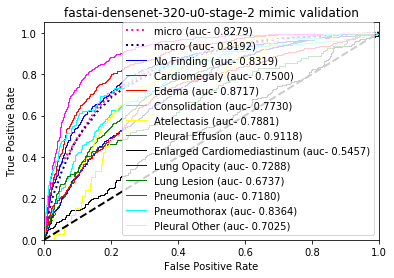

In [7]:
exp_name = 'fastai-densenet-320-u0-stage-2'
learn = cnn_learner(data, models.densenet121)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name+' mimic validation', plot_path='FinalAUC/'+exp_name+'mimic_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

test_preds += preds
exp_cnt += 1.0

FinalAUC/fastai-densenet-320-u1-stage-1mimic_valid.png


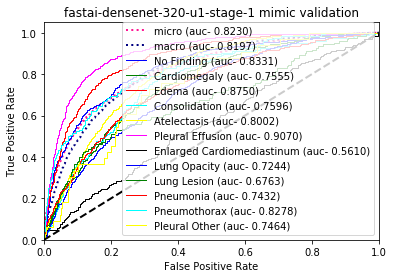

In [8]:
exp_name = 'fastai-densenet-320-u1-stage-1'
learn = cnn_learner(data, models.densenet121)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name+' mimic validation', plot_path='FinalAUC/'+exp_name+'mimic_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

test_preds += preds
exp_cnt += 1.0

FinalAUC/fastai-resnet-320-u0-stage-1mimic_valid.png


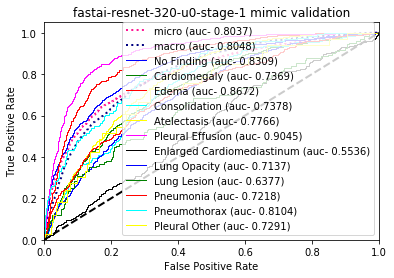

In [9]:
exp_name = 'fastai-resnet-320-u0-stage-1'
learn = cnn_learner(data, models.resnet152)
learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name+' mimic validation', plot_path='FinalAUC/'+exp_name+'mimic_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

test_preds += preds
exp_cnt += 1.0

FinalAUC/fastai-resnet-320-u1-stage-2mimic_valid.png


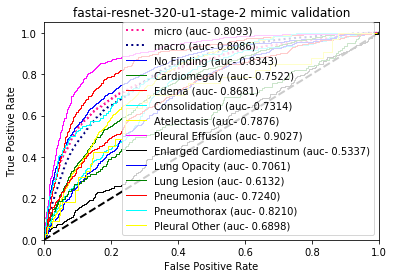

In [10]:
exp_name = 'fastai-resnet-320-u1-stage-2'
learn = cnn_learner(data, models.resnet152)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name+' mimic validation', plot_path='FinalAUC/'+exp_name+'mimic_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

test_preds += preds
exp_cnt += 1.0

FinalAUC/fastai-resnext-320-u1-stage-1mimic_valid.png


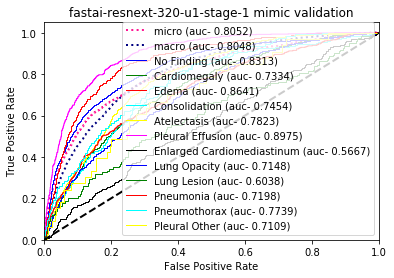

In [11]:
exp_name = 'fastai-resnext-320-u1-stage-1'

from resnext import resnext101_64x4d
model = resnext101_64x4d()
model.last_linear = nn.Sequential(nn.Linear(32768, 2048), 
                                  nn.ReLU(True),
                                  nn.Dropout(),
                                  nn.Linear(2048, 14))
learn = Learner(data, model)
learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)
learn.load(exp_name)

preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name+' mimic validation', plot_path='FinalAUC/'+exp_name+'mimic_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

test_preds += preds
exp_cnt += 1.0

FinalAUC/fastai-vgg-320-u0-stage-2mimic_valid.png


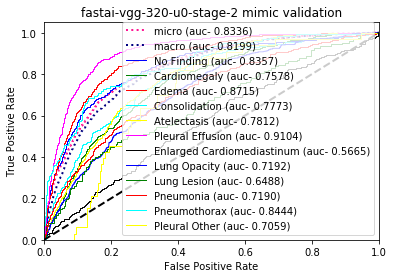

In [12]:
exp_name = 'fastai-vgg-320-u0-stage-2'
learn = cnn_learner(data, models.vgg19_bn)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name+' mimic validation', plot_path='FinalAUC/'+exp_name+'mimic_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

test_preds += preds
exp_cnt += 1.0

FinalAUC/fastai-vgg-320-u1-stage-1mimic_valid.png


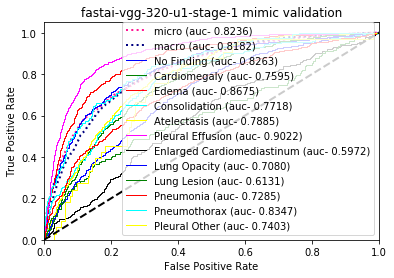

In [13]:
exp_name = 'fastai-vgg-320-u1-stage-1'
learn = cnn_learner(data, models.vgg19_bn)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name+' mimic validation', plot_path='FinalAUC/'+exp_name+'mimic_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

test_preds += preds
exp_cnt += 1.0

FinalAUC/fastai-densenet-CT-phase2-u1-stage-2mimic_valid.png


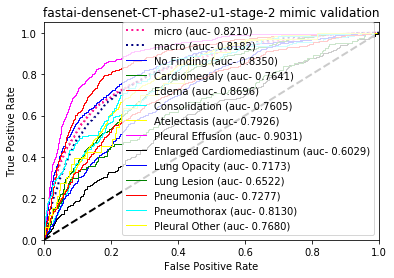

In [14]:
exp_name = 'fastai-densenet-CT-phase2-u1-stage-2'
learn = cnn_learner(data, models.densenet121)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name+' mimic validation', plot_path='FinalAUC/'+exp_name+'mimic_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

test_preds += preds
exp_cnt += 1.0

In [15]:
# exp_name = 'fastai-densenet-320-u1-lsr-stage-2'
# learn = cnn_learner(data, models.densenet121)
# learn.load(exp_name)
# preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

# rec = MyAUC.get_auc(y, preds, plot_title=exp_name+' mimic validation', plot_path='FinalAUC/'+exp_name+'mimic_valid.png')
# rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
# record_dict += [rec]
# pred_list.append(preds)

# test_preds += preds
# exp_cnt += 1.0

Loaded pretrained weights for efficientnet-b3


FinalAUC/fastai-effnetB3-320-u1-stage-1mimic_valid.png


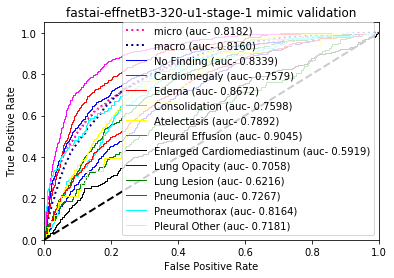

In [16]:
exp_name = 'fastai-effnetB3-320-u1-stage-1'

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b3'
def getModel():
    model = EfficientNet.from_pretrained(model_name)
#     model._bn1 = nn.Identity()
    model._fc = nn.Linear(1536,data.c)
    return model

learn = Learner(data, getModel())
# learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name+' mimic validation', plot_path='FinalAUC/'+exp_name+'mimic_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

test_preds += preds
exp_cnt += 1.0

/home/amey/.conda/envs/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


 final_simplex: (array([[ 3.650678,  1.667024, -2.335621, -1.236366, ...,  4.064821,  2.220987,  1.217625,  0.678311],
       [ 3.650694,  1.667018, -2.335635, -1.236359, ...,  4.06482 ,  2.220987,  1.217623,  0.67832 ],
       [ 3.650699,  1.667015, -2.335619, -1.23635 , ...,  4.064808,  2.220974,  1.217636,  0.678314],
       [ 3.650708,  1.667017, -2.335642, -1.236358, ...,  4.064818,  2.220985,  1.217626,  0.678323],
       ...,
       [ 3.650698,  1.66702 , -2.335677, -1.236337, ...,  4.064819,  2.220988,  1.217622,  0.678316],
       [ 3.650688,  1.667022, -2.335634, -1.236351, ...,  4.064817,  2.220981,  1.21763 ,  0.6783  ],
       [ 3.650694,  1.667034, -2.335678, -1.236341, ...,  4.064806,  2.220981,  1.217638,  0.678319],
       [ 3.650701,  1.667019, -2.335618, -1.236373, ...,  4.06483 ,  2.220984,  1.217632,  0.678294]]), array([-0.839607, -0.839607, -0.839607, -0.839607, -0.839607, -0.839607, -0.839607, -0.839607, -0.839607, -0.839607]))
           fun: -0.839607249162020

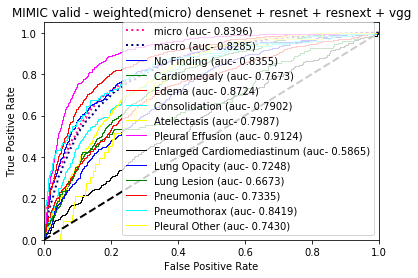

In [17]:
import scipy

wts = np.array([1]*len(pred_list))

def auc_val(w, get_wtd=False):
    wtd_pred = pred_list[0]*0
    for idx in range(len(pred_list)):
        wtd_pred += w[idx]*pred_list[idx]
    if get_wtd:
        return wtd_pred
    return -MyAUC.get_auc(y, wtd_pred, plot_title='temp', plot=False)['micro']
    

opt = scipy.optimize.minimize(auc_val, [1]*len(pred_list), bounds=(0,1), method="Nelder-Mead")

print(opt)
optimal_pred = auc_val(opt.x, get_wtd=True)

rec = MyAUC.get_auc(y, optimal_pred/exp_cnt, plot_title='MIMIC valid - weighted(micro) densenet + resnet + resnext + vgg', plot_path='FinalAUC/micro_ensemble_mimic_valid.png')
rec = ['weighted(micro) ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]

 final_simplex: (array([[ 2.965334,  2.384994, -1.482641, -0.382373, ...,  1.894911,  1.084488,  0.787564,  1.725603],
       [ 2.965342,  2.384988, -1.482631, -0.382366, ...,  1.894917,  1.084492,  0.787547,  1.725619],
       [ 2.965347,  2.385001, -1.482614, -0.382391, ...,  1.894933,  1.084489,  0.787536,  1.725613],
       [ 2.965343,  2.384991, -1.482634, -0.382362, ...,  1.894904,  1.084491,  0.787541,  1.725615],
       ...,
       [ 2.965361,  2.385005, -1.482608, -0.382409, ...,  1.894952,  1.084489,  0.787543,  1.725619],
       [ 2.965365,  2.385006, -1.482618, -0.382406, ...,  1.894938,  1.084496,  0.787523,  1.725635],
       [ 2.965366,  2.385005, -1.482711, -0.382363, ...,  1.894908,  1.084492,  0.787552,  1.725623],
       [ 2.965317,  2.384976, -1.482596, -0.382372, ...,  1.894935,  1.084484,  0.787554,  1.725604]]), array([-0.829364, -0.829364, -0.829364, -0.829364, -0.829364, -0.829364, -0.829363, -0.829363, -0.829363, -0.829362]))
           fun: -0.829363995815248

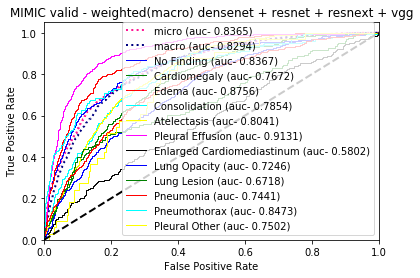

In [18]:
import scipy

wts = np.array([1]*len(pred_list))

def auc_val(w, get_wtd=False):
    wtd_pred = pred_list[0]*0
    for idx in range(len(pred_list)):
        wtd_pred += w[idx]*pred_list[idx]
    if get_wtd:
        return wtd_pred
    return -MyAUC.get_auc(y, wtd_pred, plot_title='temp', plot=False)['macro']
    

opt = scipy.optimize.minimize(auc_val, [1]*len(pred_list), bounds=(0,1), method="Nelder-Mead")

print(opt)
optimal_pred = auc_val(opt.x, get_wtd=True)

rec = MyAUC.get_auc(y, optimal_pred/exp_cnt, plot_title='MIMIC valid - weighted(macro) densenet + resnet + resnext + vgg', plot_path='FinalAUC/macro_ensemble_mimic_valid.png')
rec = ['weighted(macro) ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]

FinalAUC/equal_ensemble_mimic_valid.png


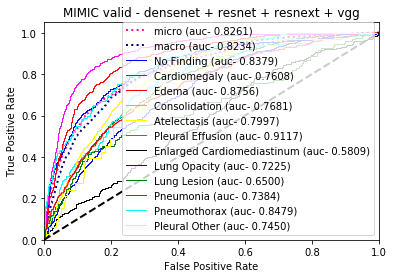

In [19]:
ens_output = auc_val([1]*int(exp_cnt), get_wtd=True)
rec = MyAUC.get_auc(y, ens_output, plot_title='MIMIC valid - densenet + resnet + resnext + vgg', plot_path='FinalAUC/equal_ensemble_mimic_valid.png')
rec = ['ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]

In [20]:
import pandas as pd

records = np.array(record_dict)
df_data = {'exp': records[:,0]}
records = np.around(np.array(records[:,1:], dtype=float), decimals=4)
df_data['micro'] = records[:,-2]
df_data['macro'] = records[:,-1]

for idx, dis in enumerate(EVAL_LBLS):
    df_data[dis] = records[:,idx]
    
record_df = pd.DataFrame(df_data)
record_df.to_csv('mimic_records.csv', index=False)
record_df

,exp,micro,macro,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
0,fastai-densenet-320-u0-stage-2,0.8279,0.8192,0.7500,0.8717,0.7730,0.7881,0.9118
1,fastai-densenet-320-u1-stage-1,0.8230,0.8197,0.7555,0.8750,0.7596,0.8002,0.9070
2,fastai-resnet-320-u0-stage-1,0.8037,0.8048,0.7369,0.8672,0.7378,0.7766,0.9045
3,fastai-resnet-320-u1-stage-2,0.8093,0.8086,0.7522,0.8681,0.7314,0.7876,0.9027
4,fastai-resnext-320-u1-stage-1,0.8052,0.8048,0.7334,0.8641,0.7454,0.7823,0.8975
5,fastai-vgg-320-u0-stage-2,0.8336,0.8199,0.7578,0.8715,0.7773,0.7812,0.9104
6,fastai-vgg-320-u1-stage-1,0.8236,0.8182,0.7595,0.8675,0.7718,0.7885,0.9022
7,fastai-densenet-CT-phase2-u1-stage-2,0.8210,0.8182,0.7641,0.8696,0.7605,0.7926,0.9031
8,fastai-effnetB3-320-u1-stage-1,0.8182,0.8160,0.7579,0.8672,0.7598,0.7892,0.9045
9,weighted(micro) ensemble,0.8396,0.8285,0.7673,0.8724,0.7902,0.7987,0.9124
